<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Day2/Part_4_Modeling_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

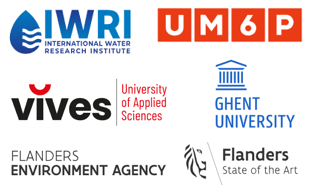<br>


**Mathematical Models and Artificial Intelligence**<br>
**for Solving Groundwater Flow Problems**<br>
Workshop organized by the<br>
International Water Research Institute (IWRI)<br>
University Mohammed VI Polytechnic<br>
January 6-7, 2025<br>
Dr. Andy Louwyck

---



<font size="6"><strong>DAY 2 - Artificial Intelligence</strong></font>

---
---

# **Part 4 - Modeling Timeseries**

This notebook illustrates how to fit a timeseries of groundwater levels. In the first section, [Pastas](https://pastas.readthedocs.io/stable/) is used, which is an open source Python package to analyse hydro(geo)logical timeseries. In the second section, [Keras](https://keras.io/) is used to train a vanilla LSTM model, which is an artifical neural network specifically designed to deal with timeseries.

## **0. Import statements**

[Pastas](https://pastas.readthedocs.io/stable/) is not installed by default in Google Colab, so we need to install it first:

In [1]:
!pip install pastas -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.5 MB/s eta 0:00:00


Additionally, we need the following libraries:
- [Keras](https://keras.io/)
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)

Importing module `inspect` will allow us to print the source code of the Pastas functions.

In [2]:
import pastas as ps
from tensorflow import keras  # Keras is TensorFlow's high-level API
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect

ps.show_versions()  # checking the versions of the packages used by Pastas

Pastas version: 1.7.0
Python version: 3.10.12
NumPy version: 1.26.4
Pandas version: 2.2.2
SciPy version: 1.13.1
Matplotlib version: 3.8.0
Numba version: 0.60.0


We also clone the maxsypy repo from GitHub to get the data files:

In [3]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy

# copy data files to current working directory
data_folder = './data'
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)
shutil.copytree("./maxsypy/seminaries/UM6P_jan_2025/data", data_folder)

# in this notebook we don't need the maxsypy package so remove it
shutil.rmtree(path)

Cloning into 'maxsypy'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 384 (delta 60), reused 5 (delta 5), pack-reused 233 (from 2)
Receiving objects: 100% (384/384), 25.09 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (167/167), done.


## **1. Pastas**



In this [example](https://pastas.readthedocs.io/stable/examples/basic_model.html) adopted from the Pastas documentation, it is shown how a simple timeseries model can be developed to simulate groundwater levels. The recharge (calculated as precipitation minus evaporation) is used as the explanatory time series.

We'll use real timeseries data that has been collected in the Netherlands:

* The rainfall data is taken from rainfall station Heibloem in The Netherlands.
* The evaporation data is taken from weather station Maastricht in The Netherlands.
* The head data is well B58C0698, which was obtained from Dino loket

### Import the dependent time series data

In this code block a time series of groundwater levels is imported using the `read_csv` function of `pandas`. As `pastas` expects a `pandas` `Series` object, the data is squeezed. To check if you have the correct data type (a `pandas Series` object), you can use `type(oseries)` as shown below.

The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a `pandas Series` object.
- The time step can be irregular.

The data type of the oseries is: <class 'pandas.core.series.Series'>


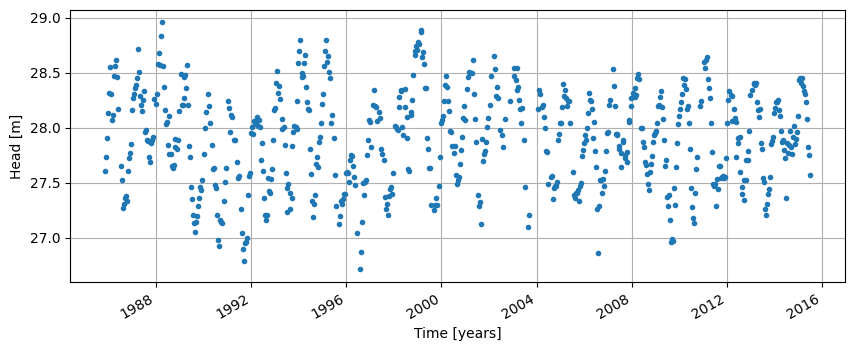

In [4]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv(
    "data/head_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the oseries is: %s" % type(gwdata))

# Plot the observed groundwater levels
gwdata.plot(style=".", figsize=(10, 4))
plt.ylabel("Head [m]");
plt.xlabel("Time [years]");
plt.grid();

Let's validate the observed timeseries using Pastas function `validate_oseries`:

In [5]:
import inspect
print(inspect.getdoc(ps.validate_oseries))

Method to validate user-provided oseries input time series.

Parameters
----------
series: pandas.Series
    Pandas.Series object containing the series time series.

Returns
-------
bool:
    True if the series is valid. If not, an error is raised.

Notes
-----
The Series are validated for the following cases:

0. Make sure the series is a Pandas.Series
1. Make sure the values are floats
2. Make sure the index is a DatetimeIndex
3. Make sure the indices are datetime64
4. Make sure the index has no NaT-values
5. Make sure the index is monotonically increasing
6. Make sure there are no duplicate indices
7. Make sure the time series has no nan-values

If any of these checks are not passed the method will throw an error that needs
to be fixed by the user.

Examples
--------

>>> ps.validate_oseries(series)


In [6]:
ps.validate_oseries(gwdata)

True

### Import the independent time series

Two explanatory series are used: the precipitation and the potential evaporation. These need to be `pandas Series` objects, as for the observed heads.

Important characteristics of these time series are:
- All series are stored as `pandas Series` objects.
- The series may have irregular time intervals, but then it will be converted to regular time intervals when creating the time series model later on.
- It is preferred to use the same length units as for the observed heads.

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>
The data type of the recharge series is: <class 'pandas.core.series.Series'>


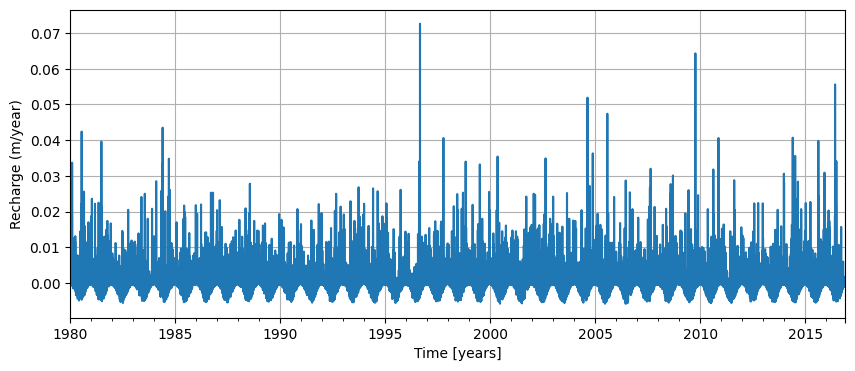

In [7]:
# Import observed precipitation series
precip = pd.read_csv(
    "data/rain_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the precip series is: %s" % type(precip))

# Import observed evaporation series
evap = pd.read_csv(
    "data/evap_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the evap series is: %s" % type(evap))

# Calculate the recharge to the groundwater
recharge = precip - evap
recharge.name = "recharge"  # set name if pandas series
print("The data type of the recharge series is: %s" % type(recharge))

# Plot the time series of the precipitation and evaporation
plt.figure()
recharge.plot(label="Recharge", figsize=(10, 4));
plt.xlabel("Time [years]");
plt.ylabel("Recharge (m/year)");
plt.grid();

Again, we may validate these series, but here, we have to use function `validate_stress`:

In [8]:
print(inspect.getdoc(ps.validate_stress))

Method to validate user-provided stress input time series.

Parameters
----------
series: pandas.Series
    Pandas.Series object containing the series time series.

Returns
-------
bool:
    True if the series is valid. If not, an error is raised.

Notes
-----
The Series are validated for the following cases:

0. Make sure the series is a Pandas.Series
1. Make sure the values are floats
2. Make sure the index is a DatetimeIndex
3. Make sure the indices are datetime64
4. Make sure the index is monotonically increasing
5. Make sure there are no duplicate indices
6. Make sure the time series has no nan-values
7. Make sure the time series has equidistant time steps

If any of these checks are not passed the method will throw an error that needs
to be fixed by the user.

Examples
--------

>>> ps.validate_stress(series)


In [9]:
ps.validate_stress(precip)

True

In [10]:
ps.validate_stress(evap)

True

### Create the timeseries model

In this code block the actual timeseries model is created. First, an instance of the `Model` class is created (named `ml` here). Second, the different components of the timeseries model are created and added to the model. The imported timeseries are automatically checked for missing values and other inconsistencies. The keyword argument `fillnan` can be used to determine how missing values are handled. If any `nan`-values are found this will be reported by `pastas`.

In [11]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

# Add the recharge data as explanatory variable
sm = ps.StressModel(recharge, ps.Gamma(), name="recharge", settings="evap")
ml.add_stressmodel(sm)

### Solve the model

The next step is to compute the optimal model parameters. The default solver uses a non-linear least squares method for the optimization. The python package `scipy` is used (info on function `least_squares` can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)). Some standard optimization statistics are reported along with the optimized parameter values and correlations.

In [12]:
ml.solve()

Fit report GWL                    Fit Statistics
nfev    11                     EVP         91.78
nobs    644                    R2           0.92
noise   False                  RMSE         0.12
tmin    1985-11-14 00:00:00    AICc     -2688.47
tmax    2015-06-28 00:00:00    BIC      -2670.66
freq    D                      Obj          4.89
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal     initial  vary
recharge_A  674.034160  215.674528  True
recharge_n    1.185049    1.000000  True
recharge_a  106.226298   10.000000  True
constant_d   27.588705   27.900078  True


### Plot the results

The solution can be plotted after a solution has been obtained.

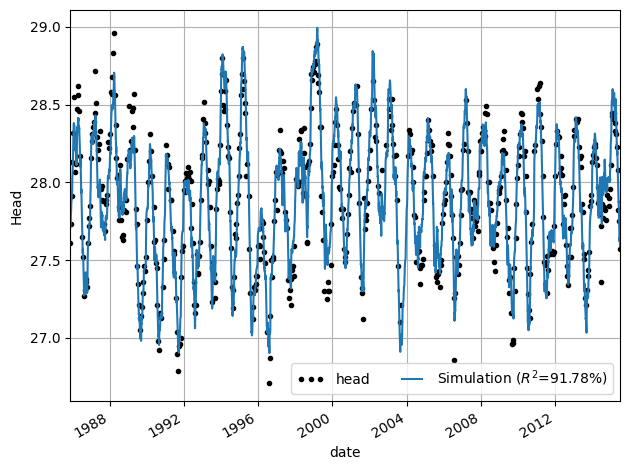

In [13]:
ml.plot();
plt.grid();

### Advanced plotting

There are many ways to further explore the timeseries model. `pastas` has some built-in functionalities that will provide the user with a quick overview of the model. The `plots` subpackage contains all the options. One of these is the method `plots.results` which provides a plot with more information.

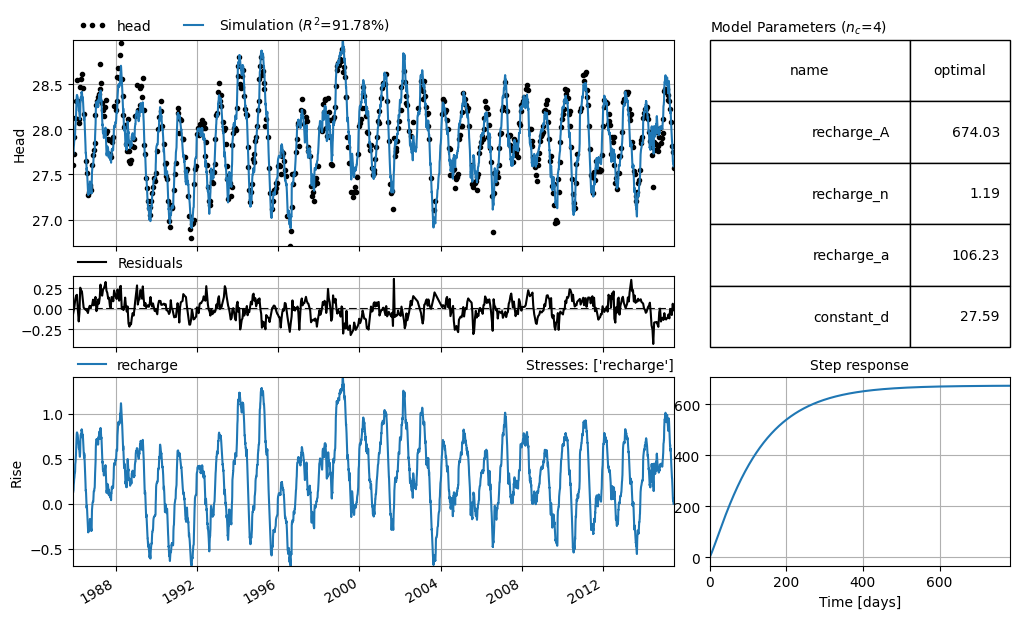

In [14]:
ml.plots.results(figsize=(10, 6));

### Statistics

The `stats` subpackage includes a number of statistical functions that may applied to the model. One of them is the `summary` method, which gives a summary of the main statistics of the model.

In [15]:
ml.stats.summary()

Value
Statistic             
rmse          0.123245
rmsn               NaN
sse           9.781998
mae           0.098034
nse           0.917782
evp          91.778169
rsq           0.917782
kge           0.940616
bic       -2670.657030
aic       -2688.527825
aicc      -2688.465227

### Forecasting

Once the model is solved, we can `simulate` groundwater levels for a future period:

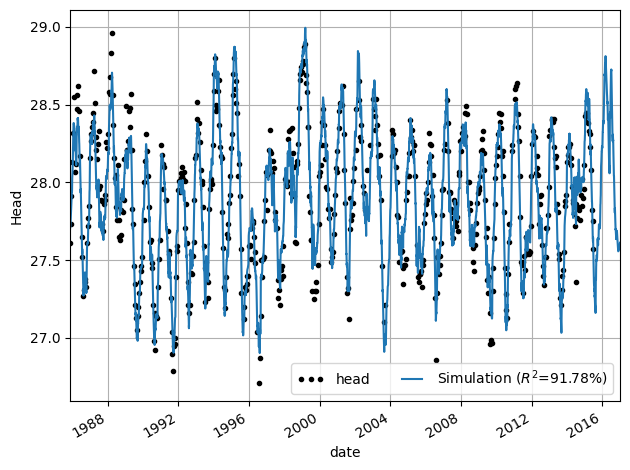

In [16]:
ml.simulate(tmax='2016-12-31')
ml.plot(tmax='2016-12-31', simulation=True)
plt.grid();

### Improvement: estimate evaporation factor

In the previous model, the recharge was estimated as precipitation minus potential evaporation. A better model is to estimate the actual evaporation as a factor (called the evaporation factor here) times the potential evaporation.

First, a new model is created (called `ml2` here so that the original model `ml` does not get overwritten). Second, the `RechargeModel` object with a `Linear` recharge model is created, which combines the precipitation and evaporation series and adds a parameter for the evaporation factor `f`. The `RechargeModel` object is added to the model, the model is solved, and the results and statistics are plotted to the screen.

Note that the new model gives a better fit (lower root mean squared error and higher explained variance), but that the [Akiake information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) indicates that the addition of the additional parameter does not improve the model signficantly (the Akaike criterion for model `ml2` is higher than for model `ml`).

In [17]:
# Create a model object by passing it the observed series
ml2 = ps.Model(gwdata)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(
    precip,
    evap,
    ps.Gamma(),
    name="rainevap",
    recharge=ps.rch.Linear(),
    settings=("prec", "evap"),
)
ml2.add_stressmodel(ts1)

# Solve the model
ml2.solve()

Fit report head                   Fit Statistics
nfev    13                     EVP         93.28
nobs    644                    R2           0.93
noise   False                  RMSE         0.11
tmin    1985-11-14 00:00:00    AICc     -2816.26
tmax    2015-06-28 00:00:00    BIC      -2794.01
freq    D                      Obj          4.00
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
               optimal     initial  vary
rainevap_A  618.950900  215.674528  True
rainevap_n    1.049266    1.000000  True
rainevap_a  146.190549   10.000000  True
rainevap_f   -1.408104   -1.000000  True
constant_d   28.019644   27.900078  True


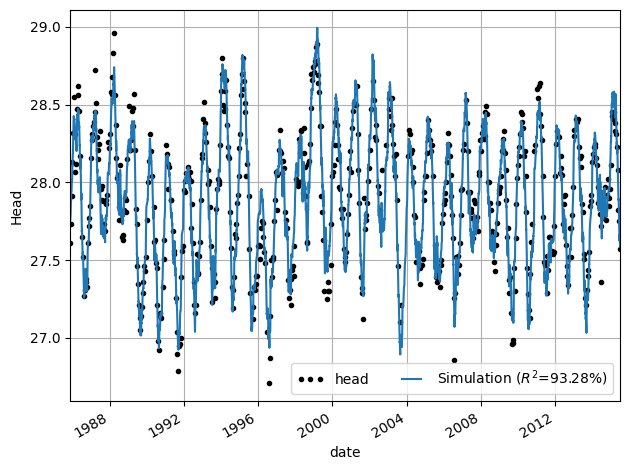

In [18]:
# Plot the results
ml2.plot()
plt.grid();

In [19]:
# Statistics
ml2.stats.summary()

Value
Statistic             
rmse          0.111429
rmsn               NaN
sse           7.996130
mae           0.086444
nse           0.932792
evp          93.279202
rsq           0.932792
kge           0.951650
bic       -2794.010733
aic       -2816.349227
aicc      -2816.255183

## **2. Vanilla LSTM**

A vanilla LSTM is an artifical neural network that has a single hidden layer of LSTM units, and an output layer used to make a prediction. LSTMs are typically used to handle timeseries data. With TensorFlow Keras, it is very straightforward to train such a model, which will be illustrated here using the timeseries data we modeled in the previous section. To speed up the coding, we make use of [Gemini](https://en.wikipedia.org/wiki/Gemini_(chatbot), which is available for free in Google Colab.

### Prepare the data

First, we create a Pandas `DataFrame` containing the groundwater levels, evaporation, and precipitation data from the previous section. Since the series have different time stamps, we'll retain the common time stamps to obtain a regular multivariate timeseries:

In [20]:
# prompt: I want a Pandas Dataframe that contains Series gwdata, evap and precip.
# The Series have different time stamps. Make sure only the same time stamps are kept.

# Combine the time series into a single DataFrame
df = pd.DataFrame({'gwdata': gwdata, 'evap': evap, 'precip': precip})

# Use the intersection of all index values to keep only common timestamps
common_index = gwdata.index.intersection(evap.index).intersection(precip.index)

# Create a new DataFrame with only the common timestamps
df_aligned = df.loc[common_index]

# Print the resulting DataFrame
df_aligned

gwdata    evap  precip
date                              
1985-11-14   27.61  0.0005  0.0022
1985-11-28   27.73  0.0003  0.0086
1985-12-14   27.91  0.0001  0.0037
1985-12-28   28.13  0.0002  0.0012
1986-01-13   28.32  0.0001  0.0025
...            ...     ...     ...
2015-04-28   28.23  0.0025  0.0000
2015-05-14   28.08  0.0032  0.0000
2015-05-28   27.82  0.0025  0.0000
2015-06-14   27.75  0.0045  0.0008
2015-06-28   27.57  0.0042  0.0000

[644 rows x 3 columns]

Checking whether there are missing values:

In [21]:
df_aligned.isna().any()

gwdata    False
evap      False
precip    False
dtype: bool

There are no missing values, so we're good to go. Let's plot the three series:

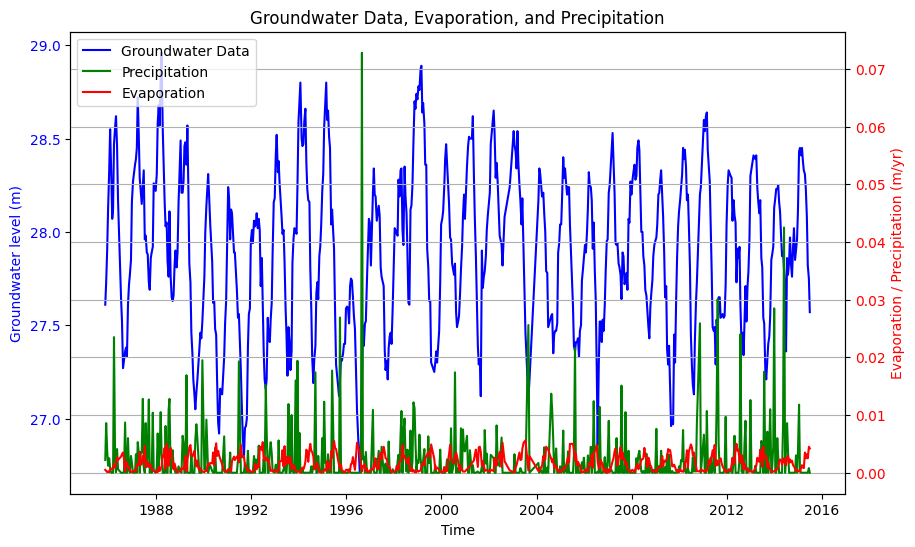

In [22]:
# prompt: Make a line plot with two y-axis, the left axis is for gwdata, the right axis for evap and precip

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot gwdata on the left y-axis
ax1.plot(df_aligned.index, df_aligned['gwdata'], color='blue', label='Groundwater Data')
ax1.set_xlabel("Time")
ax1.set_ylabel("Groundwater level (m)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for evap and precip
ax2 = ax1.twinx()
ax2.plot(df_aligned.index, df_aligned['precip'], color='green', label='Precipitation')
ax2.plot(df_aligned.index, df_aligned['evap'], color='red', label='Evaporation')
ax2.set_ylabel("Evaporation / Precipitation (m/yr)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Groundwater Data, Evaporation, and Precipitation')
plt.grid(True)
plt.show()

Neural nets don't like big numbers, so we have to scale the groundwater levels. We do that using Scikit-Learn's `MinMaxScaler`, which applies the following formula:

> $X_{scaled} = \dfrac{X-\min(X)}{\max(X)-\min(X)}$

In [23]:
# prompt: Scale column gwdata in df_aligned using sklearn MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

# Copy df_aligned
df_scaled = df_aligned.copy()

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the 'gwdata' column
df_scaled['gwdata'] = scaler.fit_transform(df_scaled[['gwdata']])

### The sliding window method

Finally, we need to convert the timeseries into a supervised learning data structure. We do this by applying *the sliding window method* implemented with the Keras function `timeseries_dataset_from_array()`:

In [24]:
# convert the timeseries into a NumPy array
ts = df_scaled[['gwdata', 'evap', 'precip']].values

# length of the window and batch size
window = 10
batch_size = 16

# create the dataset using the sliding window method
dataset = keras.utils.timeseries_dataset_from_array(
    data=ts,                                             # we use all features: gwdata, evap and precip
    targets=ts[window:, df_scaled.columns == 'gwdata'],  # we only want to fit gwdata
    sequence_length=window,                              # length of window (targets not included)
    batch_size=batch_size,                               # batch size
)

The sliding window method chops the time series into segments of length 10 and takes the data point after each segment as the target. The LSTM model will then use these smaller time series to learn to predict the next point. The animation below shows how this works for the first part of the time series:

In [25]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

table = np.vstack([np.hstack((X[:, :, 0].numpy(), y)) for X, y in dataset])
rows = range(100)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

def init():
    ax.plot(ts[rows[0]:rows[-1]+window+1, 0], linestyle='-', color='gray');
    ax.grid();
    ax.set_xlabel('timestep');
    ax.set_ylabel('head (m)');
    ax.set_title('the sliding window method');

def update(k):
    for line in ax.get_lines():
        if line.get_color() in ['k', 'r']: line.remove()
    i = k + np.arange(table.shape[1])
    ax.plot(i[:-1], table[k, :-1], 'k.-');
    ax.plot(i[-1], table[k, -1], 'r.');

anim = FuncAnimation(fig, update, frames=rows, init_func=init, blit=False)
plt.close()
anim

Model input `X` consists of the black series, which are made up of 10 data points, and output `y` is the red point after each black series. What the animation does not show is that input `X` also contains the corresponding data points from the evaporation and precipitation timeseries. So the black series are actually matrices of 10 x 3 elements. Since the original timeseries consists of 644 samples, input `X` is an array of 634 x 10 x 3 data points, and output `y` a column vector of 634 elements:

In [26]:
X = np.vstack(([batch_X[:, :, :].numpy() for batch_X, batch_y in dataset]))
y = np.vstack(([batch_y.numpy() for batch_X, batch_y in dataset]))

print(f'shape of input X: {X.shape}')
print(f'shape of output y: {y.shape}')

shape of input X: (634, 10, 3)
shape of output y: (634, 1)


### Build the model

We build a vanilla LSTM model with 8 units in the LSTM layer. The output layer has 1 node as we only want to predict the groundwater level. Because this is a regression task, this output layer has no activation function:

In [27]:
n_neurons = 8

model = keras.Sequential([
    keras.layers.Input(shape=(window, 3)),  # input size is (number of time steps, number of features)
    keras.layers.LSTM(n_neurons),           # one LSTM layer with 8 units
    keras.layers.Dense(1)                   # output layer with 1 unit as only gw head is predicted
])

### Compile the model

In the compiling step, we define an optimizer to solve the model, the loss function which is minimized by the optimizer, and an evaluation metric. Here, we use the Adam optimizer, which is an extended version of [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Because the model performs a regression task, we define the [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function and the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) as the evaluation metric:

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

### Train the model

We are now ready to train the model using the prepared `dataset`! We define 1000 `epochs`, and because of this large number of epochs, we suppress printing by setting `verbose` to 0:

In [ ]:
result = model.fit(dataset, epochs=1000, verbose=0)

It's always a good idea to plot the evolution of the loss score and the evaluation metric as a function of the number of epochs. Here, we see that the model trains well as it converges to a solution:

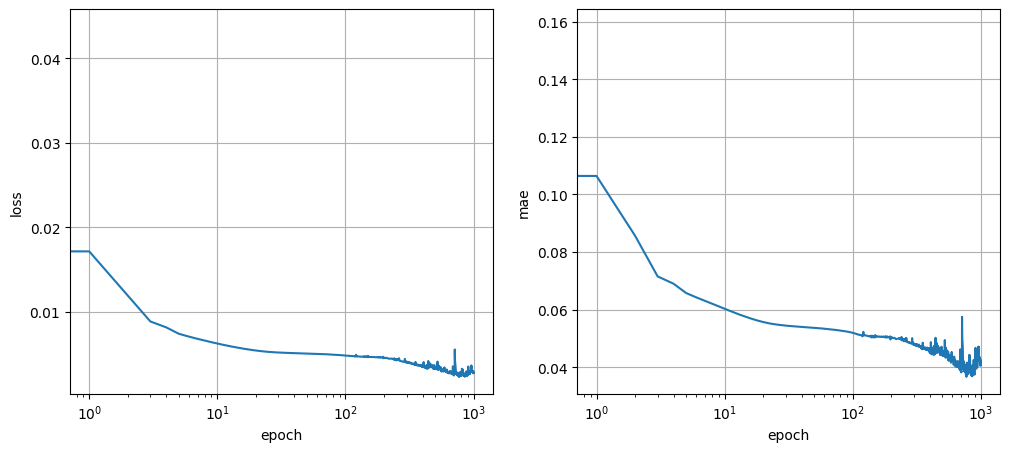

In [ ]:
def plot_loss(result, plot_type='plot'):
    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, key in zip(axes, result.history.keys()):
        getattr(ax, plot_type)(result.history[key]);
        ax.set_xlabel('epoch');
        ax.set_ylabel(key);
        ax.grid();

plot_loss(result, 'semilogx');

### Evaluate the model

Evaluating the model indeed gives a relatively small MAE:

In [ ]:
_, mae = model.evaluate(dataset, verbose=0)
print(f'MAE = {mae:.5f}')

MAE = 0.03867


Calculating the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) R² confirms the model produces an accurate fit:

In [ ]:
from sklearn.metrics import r2_score

gwdata_fitted = model.predict(dataset, verbose=0)
gwdata_fitted = scaler.inverse_transform(gwdata_fitted).squeeze()
R2 = r2_score(df_aligned['gwdata'][window:], gwdata_fitted)
R2

0.931549415704952

### Plot the result

Finally, let's plot the result to see it with our own eyes!

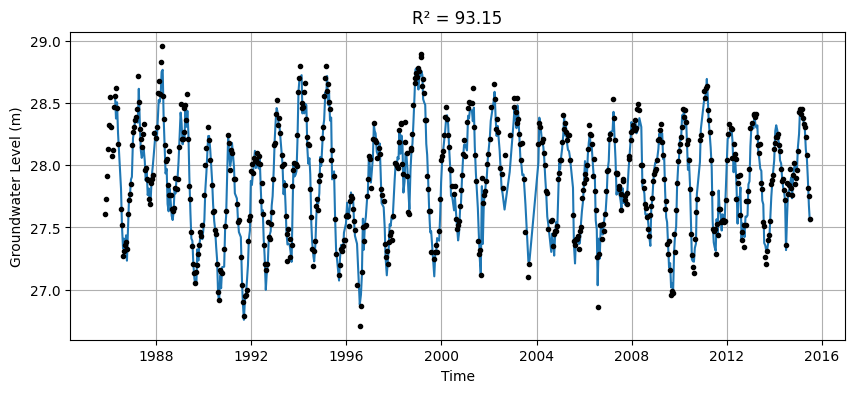

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_aligned.index[window:], gwdata_fitted, label='Fitted')
plt.plot(df_aligned.index, df_aligned['gwdata'], 'k.', label='Observed')
plt.grid();
plt.xlabel("Time");
plt.ylabel("Groundwater Level (m)");
plt.title(f'R² = {100 * R2:.2f}');

That is a nice fit of the observed groundwater levels! However, to use the model to forecast the groundwater level for the next time steps, we need to train a model that also predicts precipitation and evaporation.

---